In [123]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns


In [124]:
entire_df = pd.read_csv('data.csv') # Load the file
entire_df.head() # check the first few rows, to see if it has laoded correctly

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Split the data

In [125]:
train, test = train_test_split(entire_df, train_size=0.7, random_state=42)
train, validation = train_test_split(train, train_size=0.7, random_state=42)

In [126]:
print(train.shape, validation.shape, test.shape) # check if it is correct

(3341, 96) (1432, 96) (2046, 96)


## DEV TEAM

In [127]:
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0:1]
y_train = y_train.values.ravel() # flattens the df to 1-dim array


x_val = validation.iloc[:, 1:]
y_val = validation.iloc[:, 0:1]
y_val = validation.values.ravel() # flattens the df to 1-dim array
y_val = validation.iloc[:, 0].values.ravel()

df_x = x_val
df_y = y_val

## VALIDATION TEAM ONLY

### (ctrl + /) on the cells content to uncomment ;)

In [128]:
# train, test = train_test_split(entire_df, train_size=0.7, random_state=42)
# train, validation = train_test_split(train, train_size=0.7, random_state=42)

# x_train = train.iloc[:, 1:]
# y_train = train.iloc[:, 0].values.ravel()


# x_val = validation.iloc[:, 1:]
# y_val = validation.iloc[:, 0].values.ravel()

# df_x = x_val
# df_y = y_val

# x_test = test.iloc[:, 1:]
# y_test = test.iloc[:, 0].values.ravel()

# df_x = x_test
# df_y = y_test

## END OF VALIDATION TEAM ONLY

In [129]:
def filter_data(input_df, train_x_df): # Applies the same changes for multiple df
    threshold = 0.00 # Selecting the variance threshold - very low
    sel = VarianceThreshold(threshold=threshold)
    transformed_features = sel.fit_transform(train_x_df)
    selected_columns = sel.get_support(indices=True)
    selected_columns = input_df.columns[selected_columns]
    selected_df = input_df[selected_columns]
    selected_df # df with the low variance columns removed
    return selected_df

In [130]:
def replace_outliers_with_iqr(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Zastępowanie outlierów medianą kolumny
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), df[col].median(), df[col])
    
    return df

In [131]:
def normalize_data(input_df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(input_df)
    normalized_df = pd.DataFrame(normalized_data, columns=input_df.columns)
    return normalized_df

In [132]:
def calculate_metrics(actual, predictions):
    """
    as actual use the real data, as predictions use the predicted values
    
    Helper func. to calculate multiple scores
    """
    # Compute accuracy
    accuracy = accuracy_score(actual, predictions)

    # Compute precision
    precision = precision_score(actual, predictions, zero_division='warn')

    # Compute recall
    recall = recall_score(actual, predictions)

    # Compute F1-score
    f1 = f1_score(actual, pred)
    # Print all the metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    
    cm = confusion_matrix(df_y, predictions)

    # Calculate percentages
    total = cm.sum()
    fp_percent = (cm[0, 1] / total) * 100
    fn_percent = (cm[1, 0] / total) * 100
    tp_percent = (cm[1, 1] / total) * 100
    tn_percent = (cm[0, 0] / total) * 100

    # Create matrix plot
    plt.figure(figsize=(8, 6))
    sns.heatmap([[tn_percent, fp_percent], [fn_percent, tp_percent]], annot=True, fmt=".2f", cmap="YlGn", cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'], annot_kws={"color": "black"})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(f'fp percent:{fp_percent}, fn percent:{fn_percent}, tp percent:{tp_percent}, tn percent:{tn_percent}')


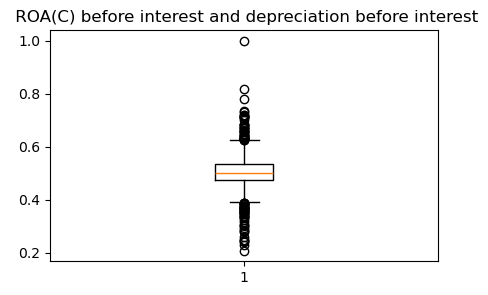

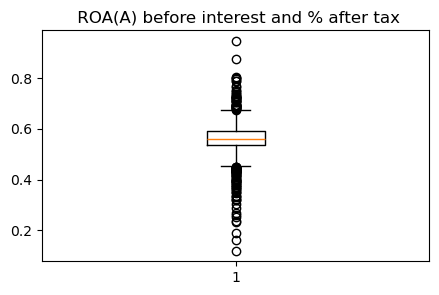

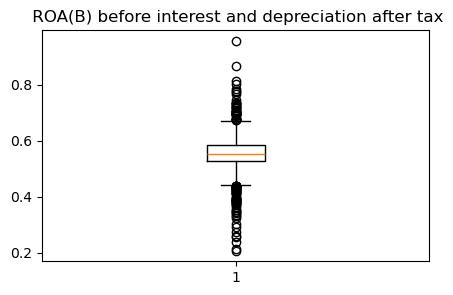

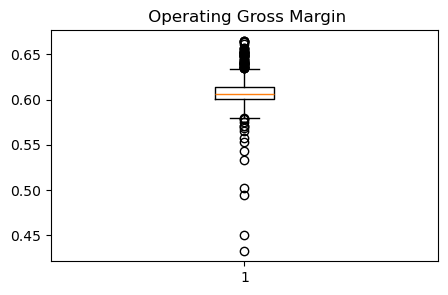

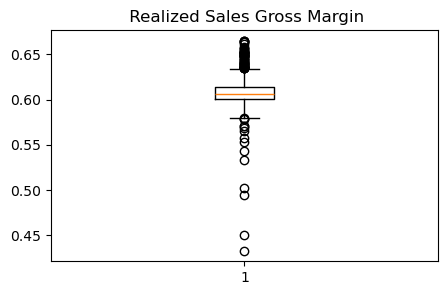

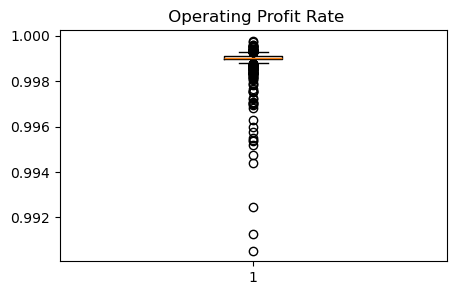

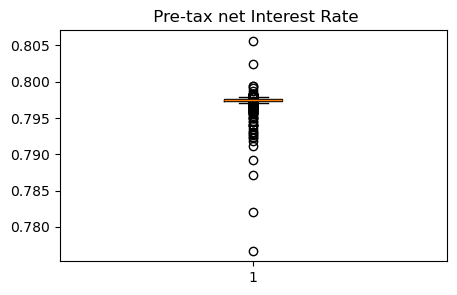

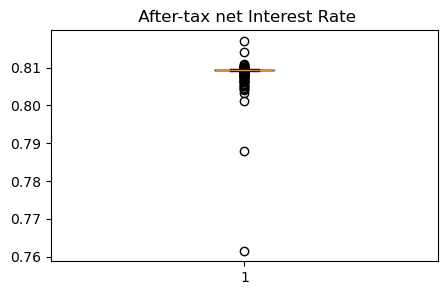

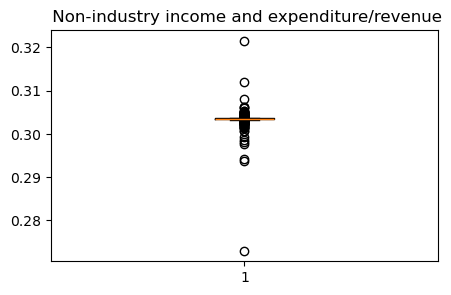

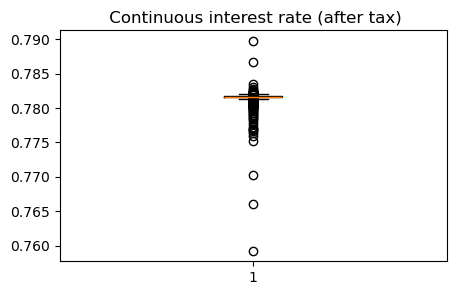

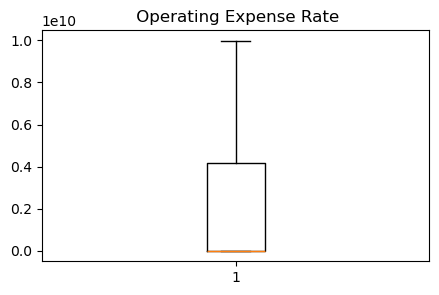

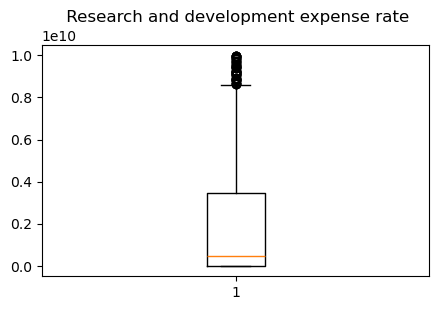

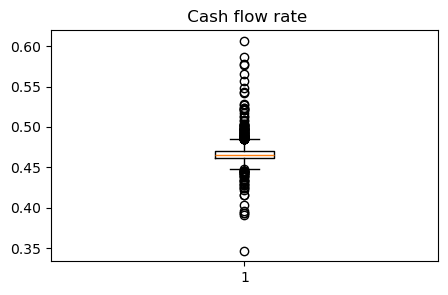

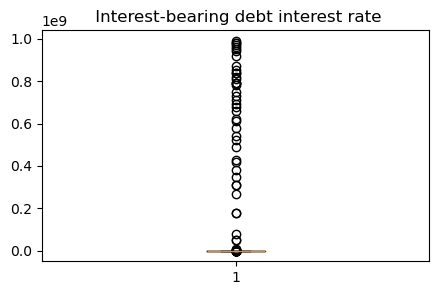

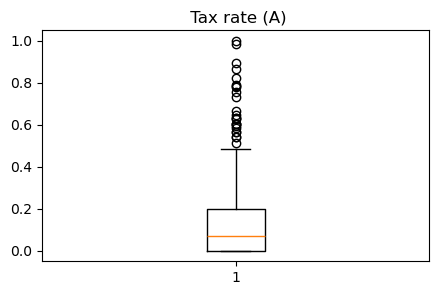

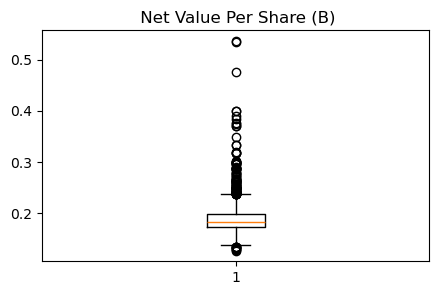

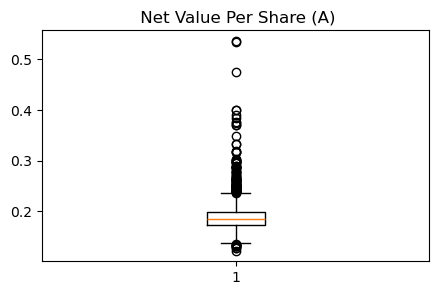

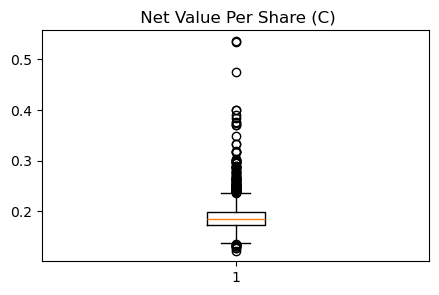

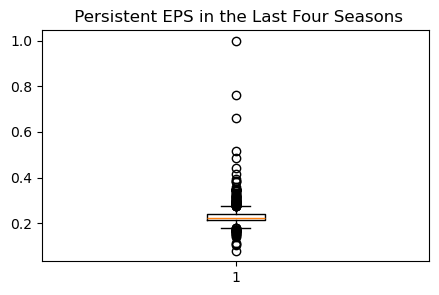

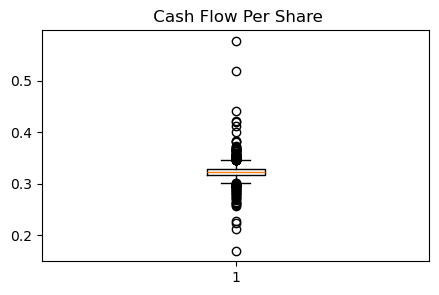

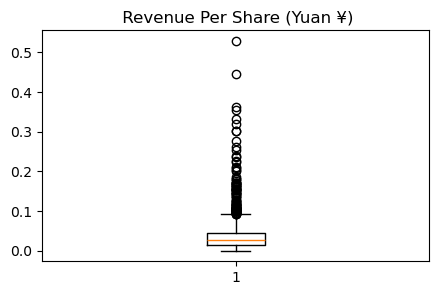

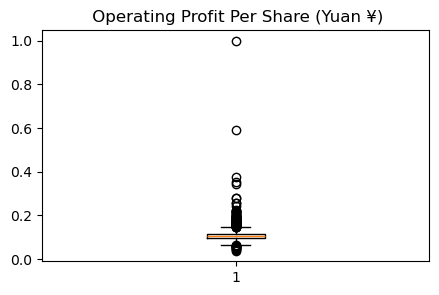

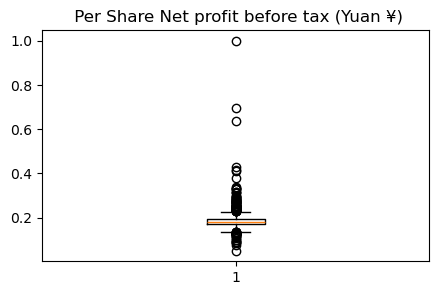

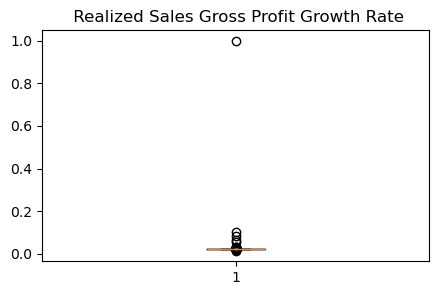

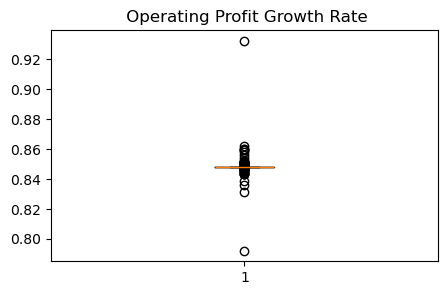

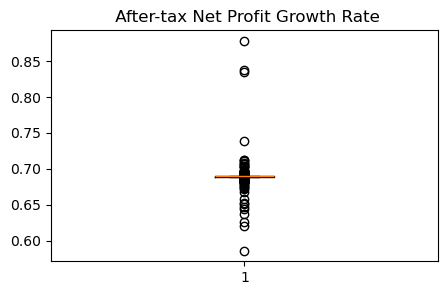

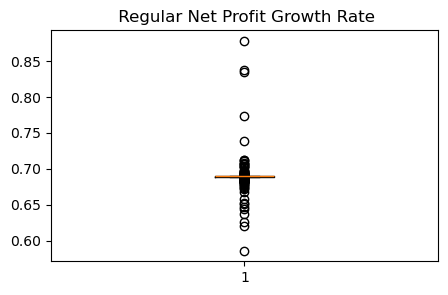

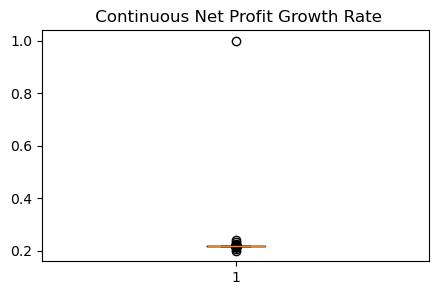

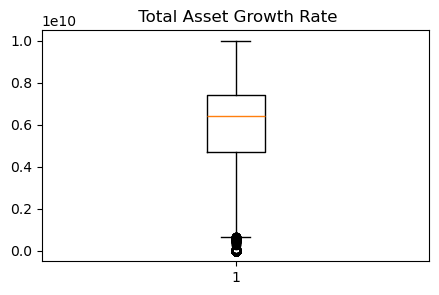

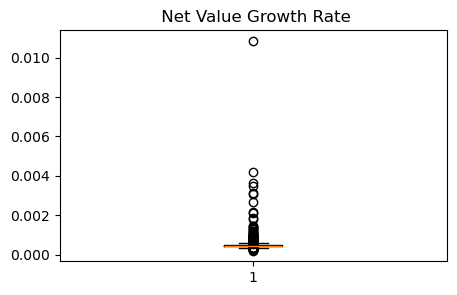

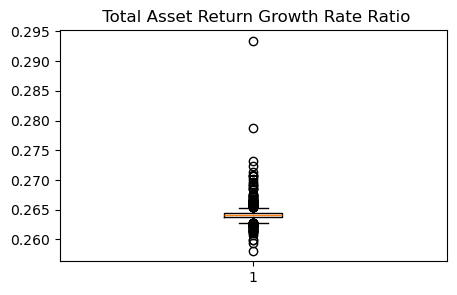

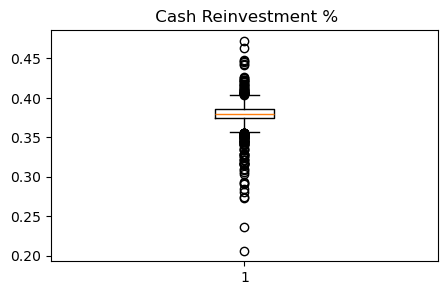

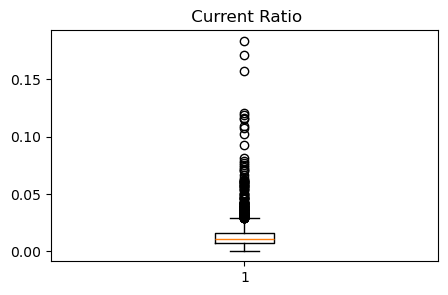

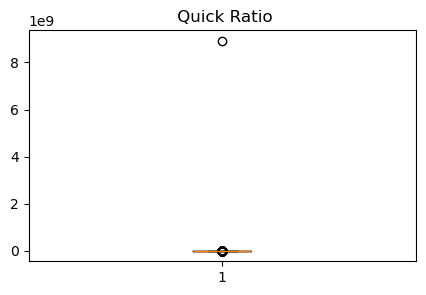

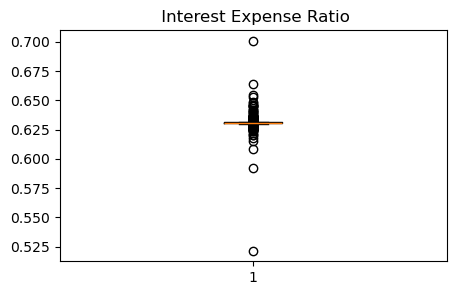

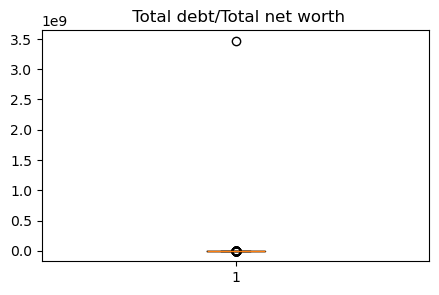

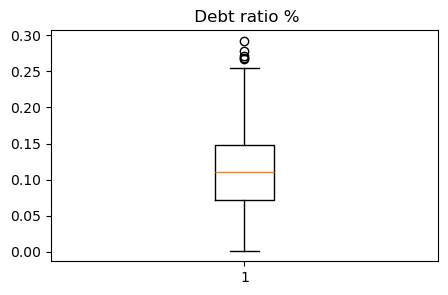

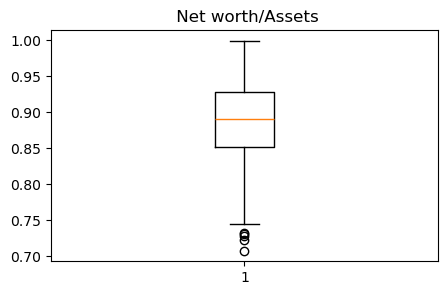

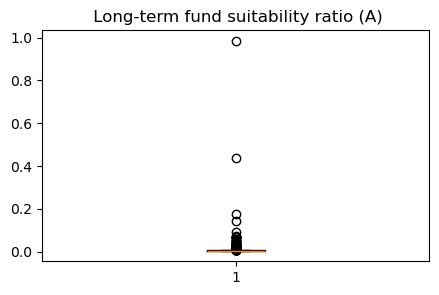

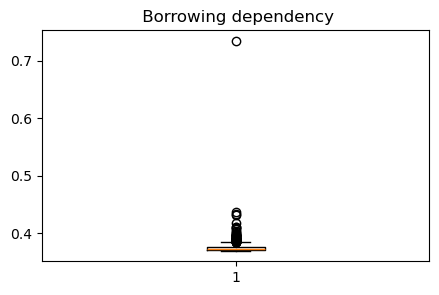

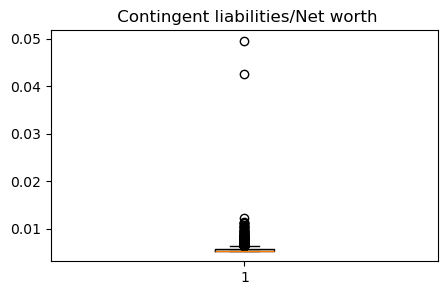

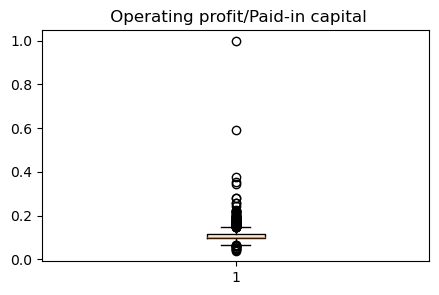

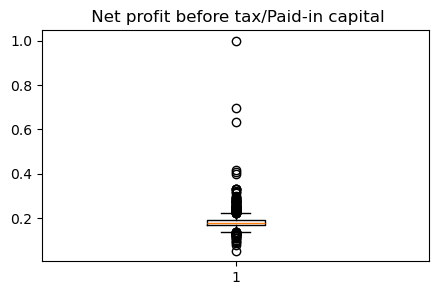

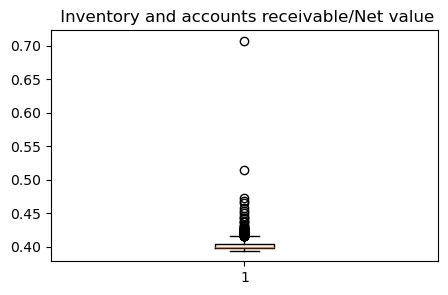

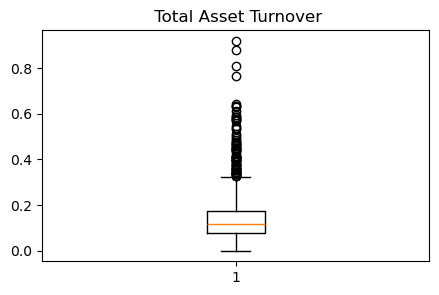

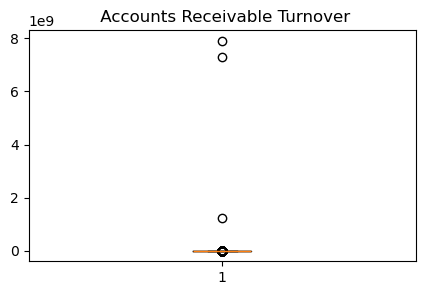

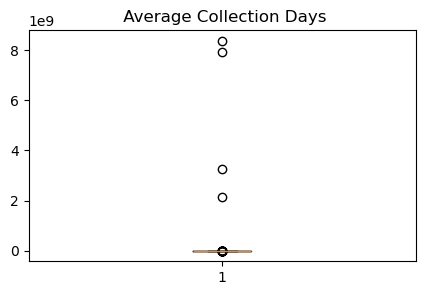

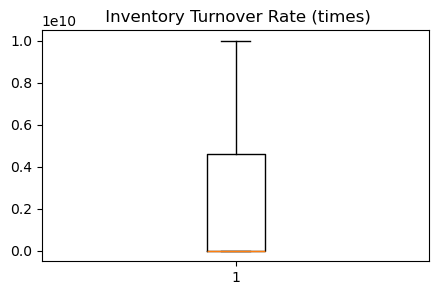

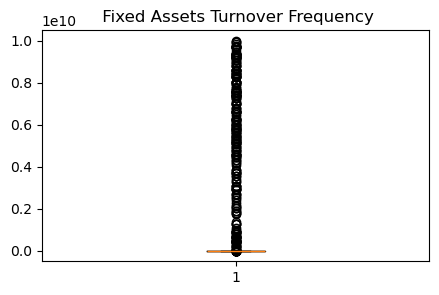

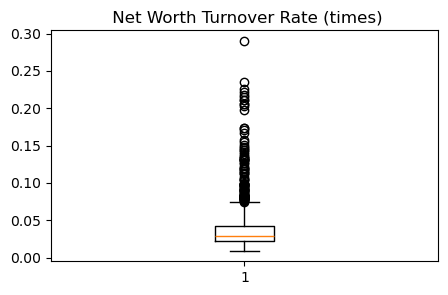

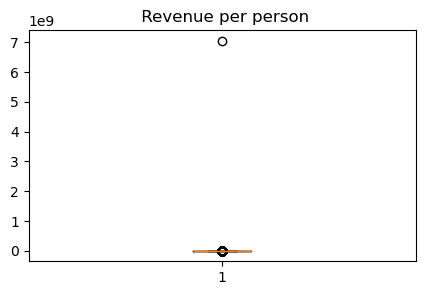

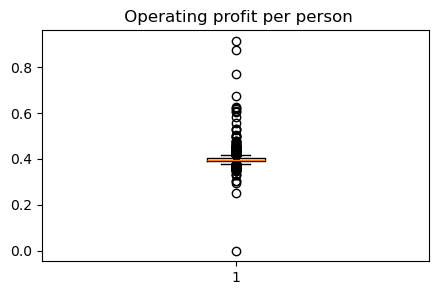

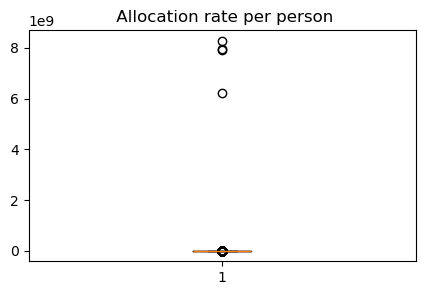

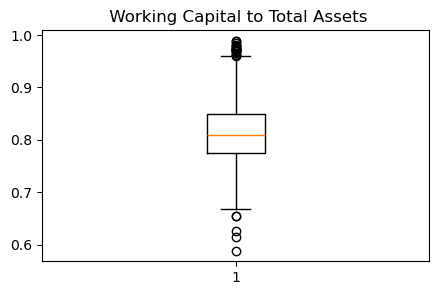

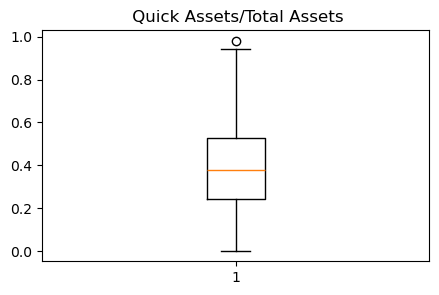

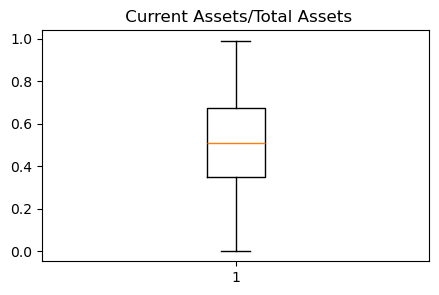

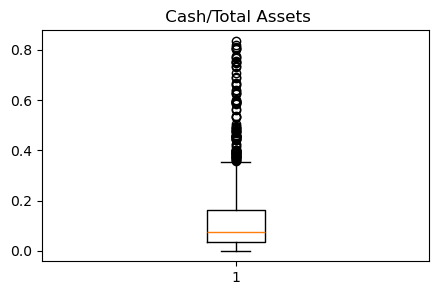

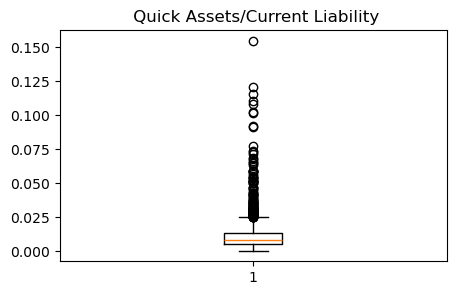

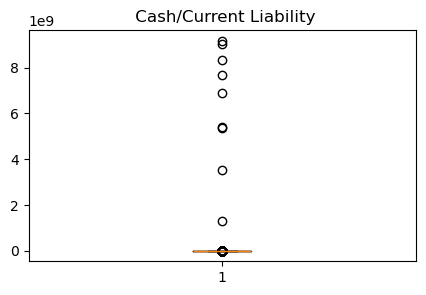

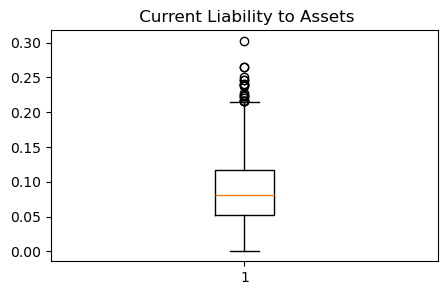

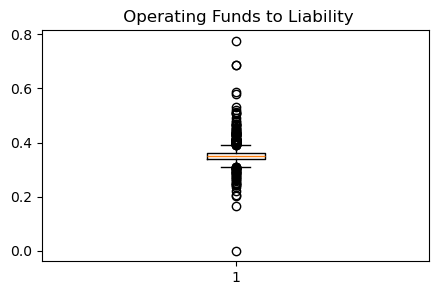

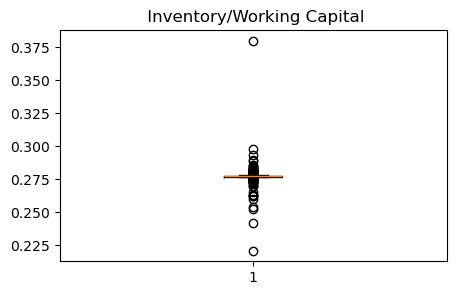

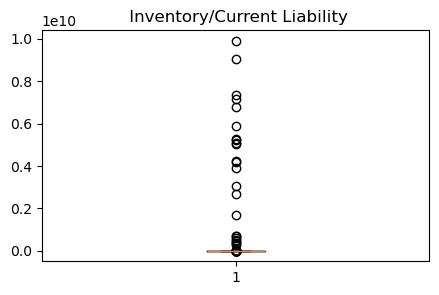

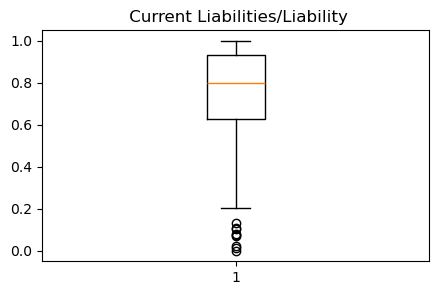

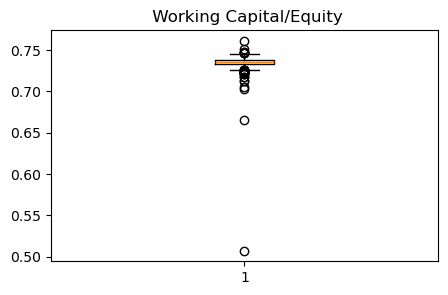

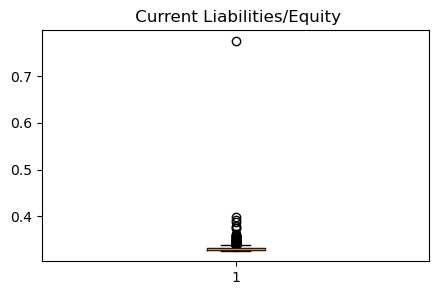

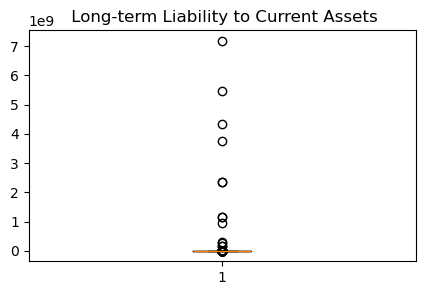

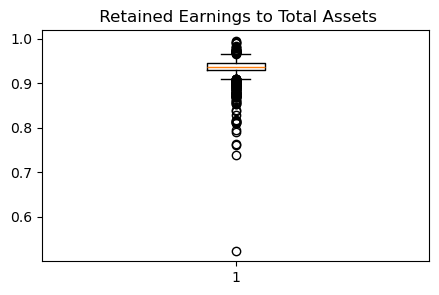

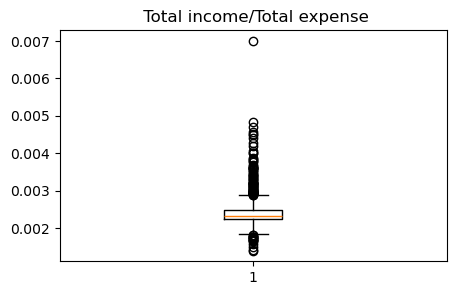

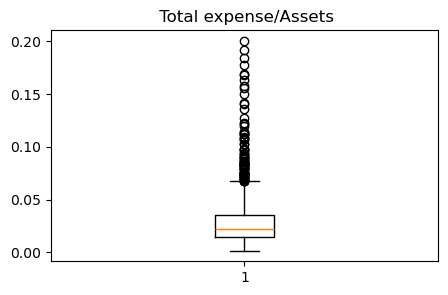

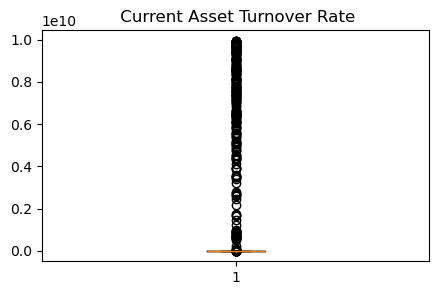

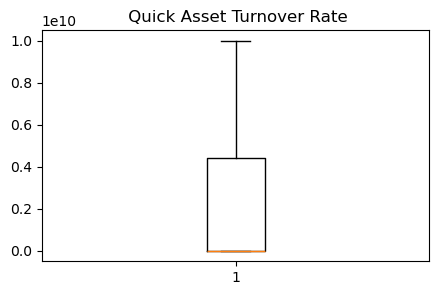

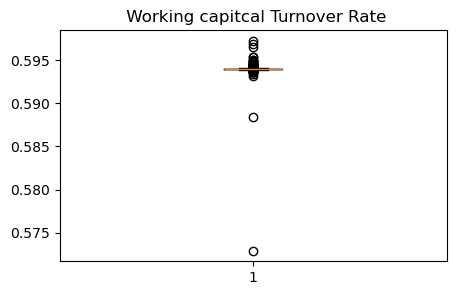

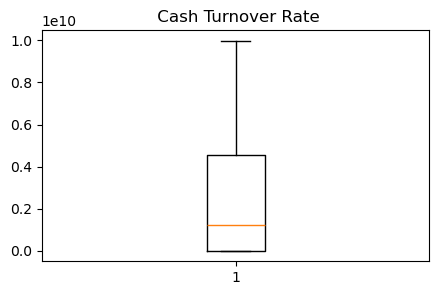

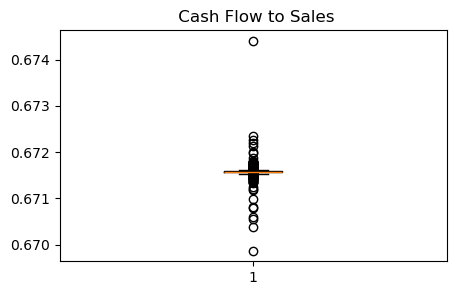

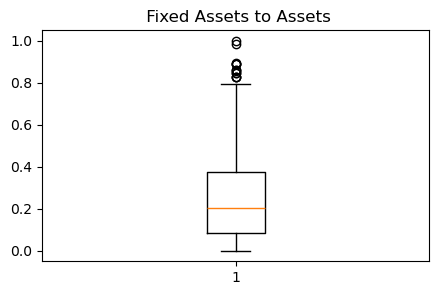

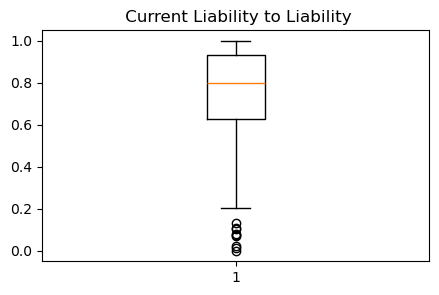

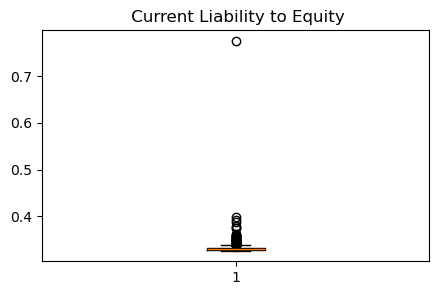

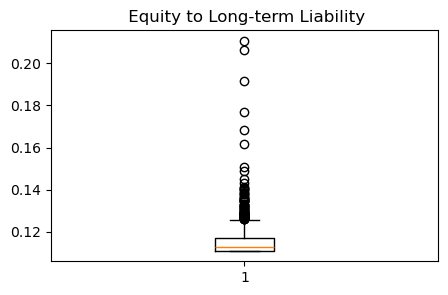

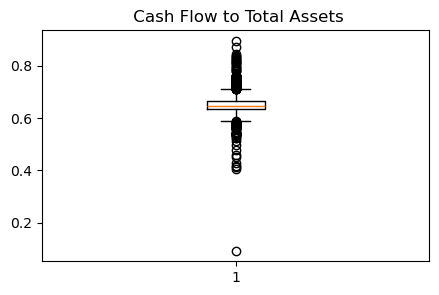

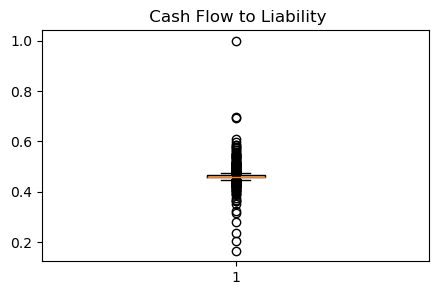

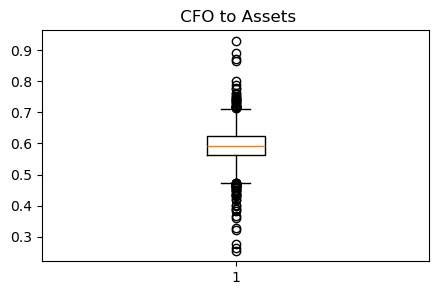

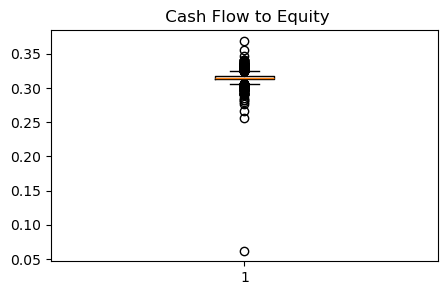

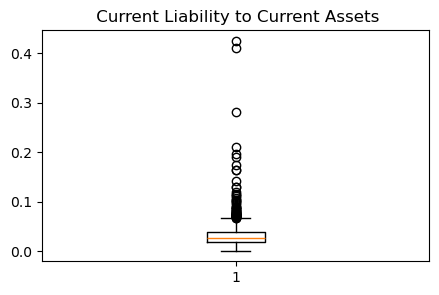

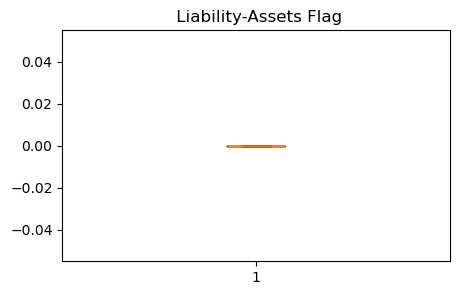

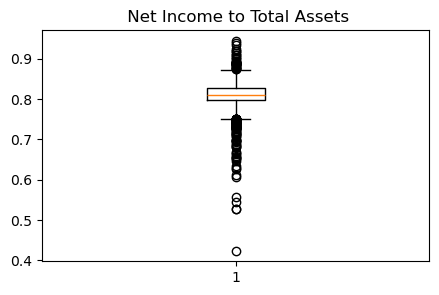

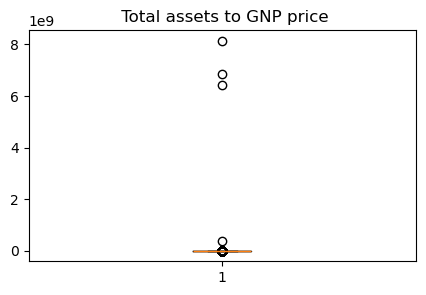

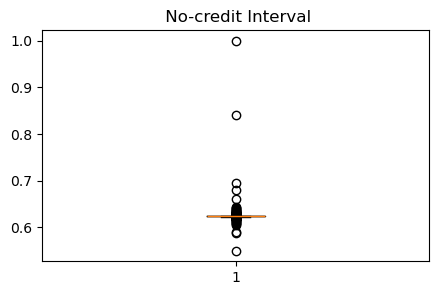

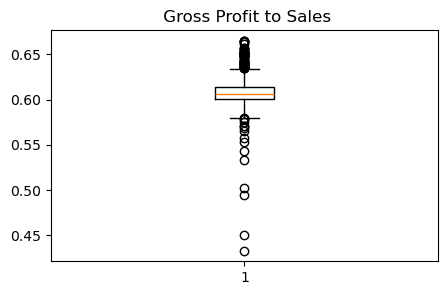

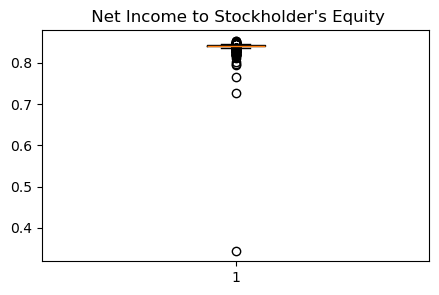

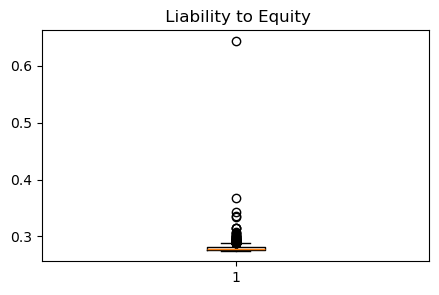

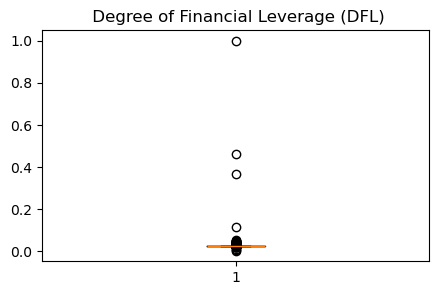

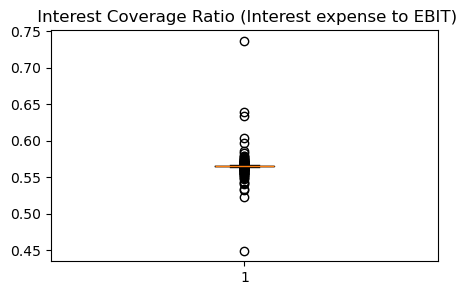

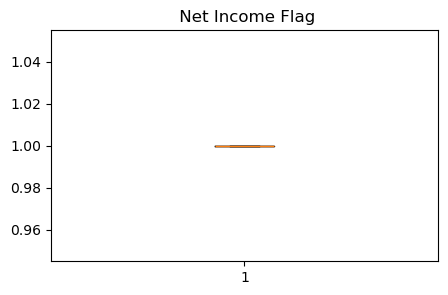

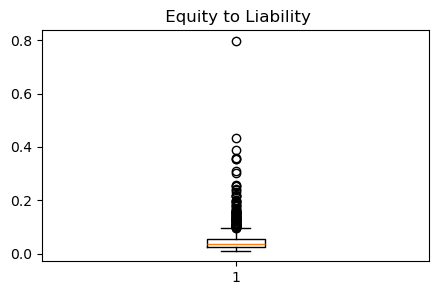

In [133]:
for column in df_x.columns:
    plt.figure(figsize=(5, 3))  # Rozmiar każdego wykresu
    plt.boxplot(df_x[column])  # Rysowanie wykresu pudełkowego dla konkretnej zmiennej
    plt.title(column)  # Tytuł wykresu
    plt.show()

In [118]:
df_x = filter_data(df_x, x_train)
x_train = filter_data(x_train, x_train)
df_x = replace_outliers_with_iqr(df_x)
x_train = replace_outliers_with_iqr(x_train)

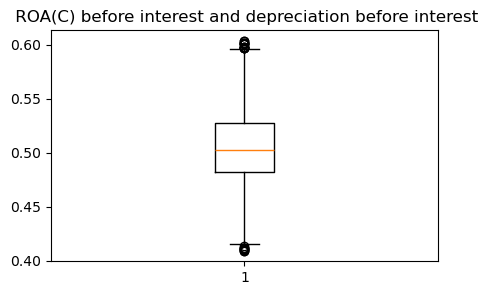

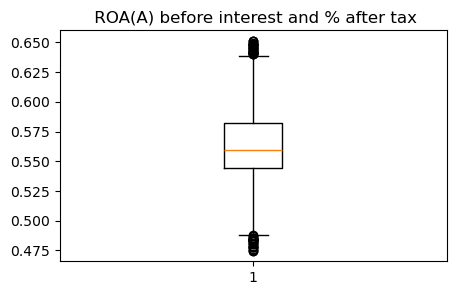

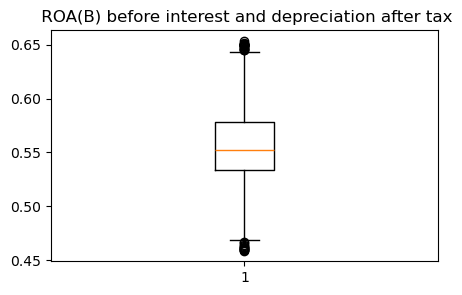

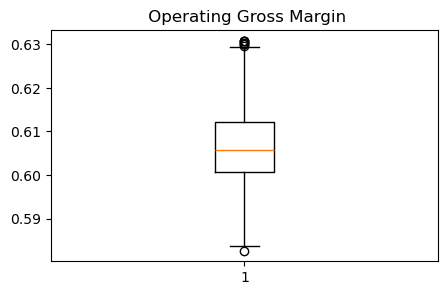

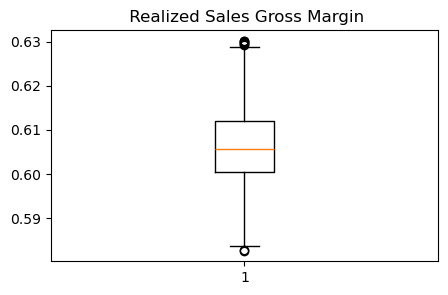

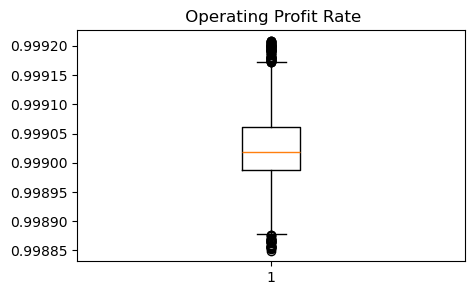

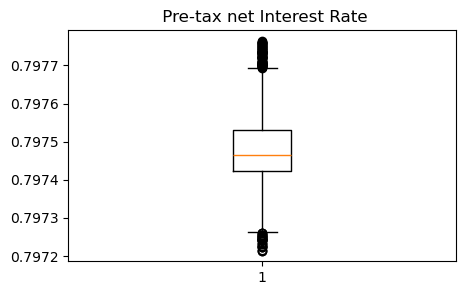

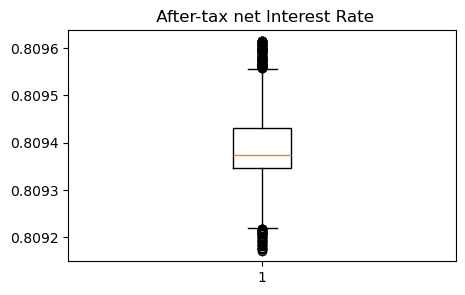

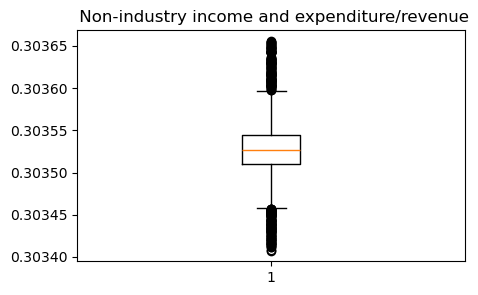

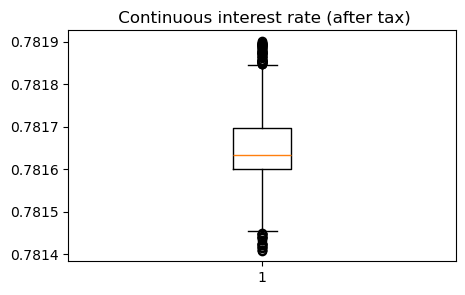

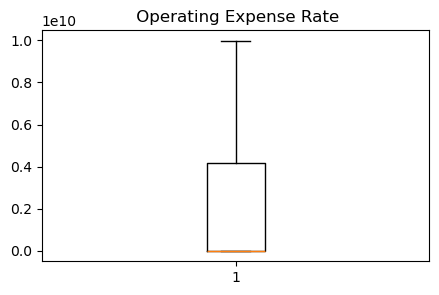

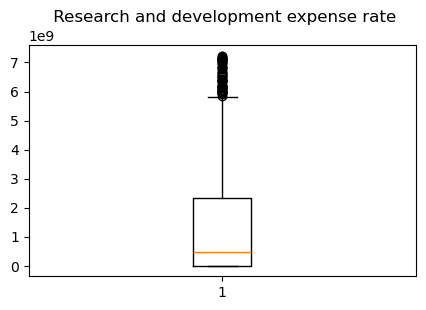

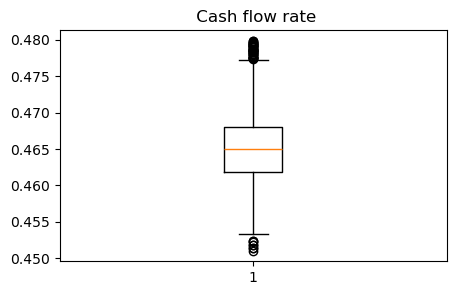

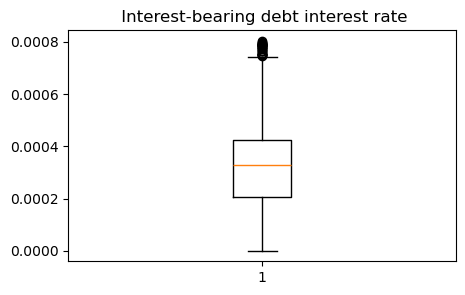

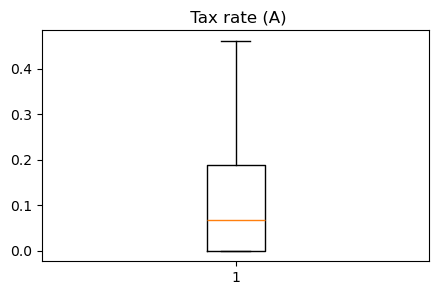

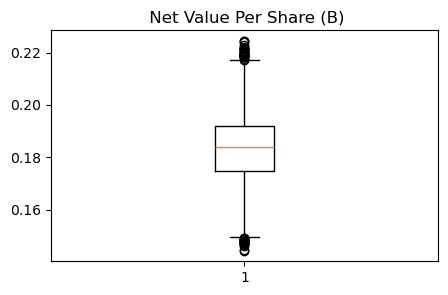

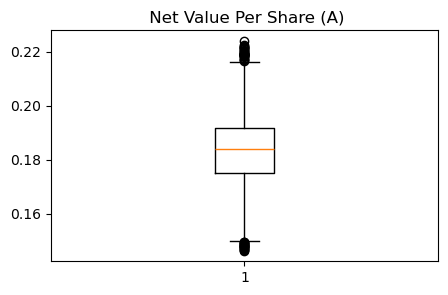

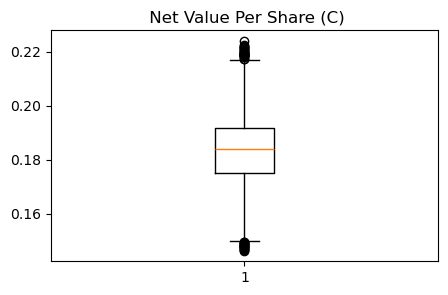

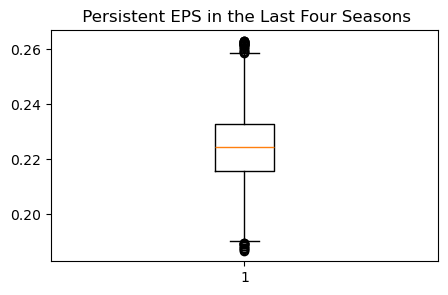

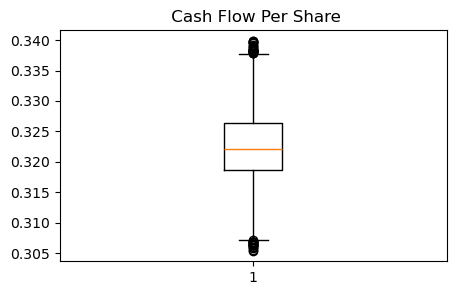

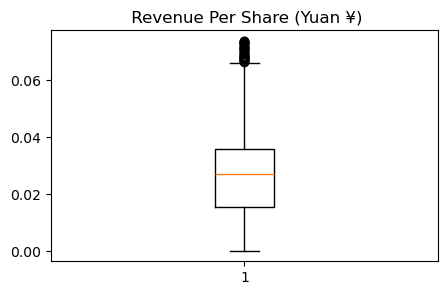

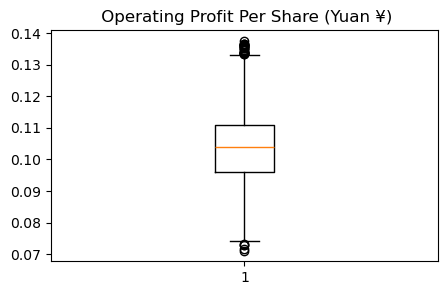

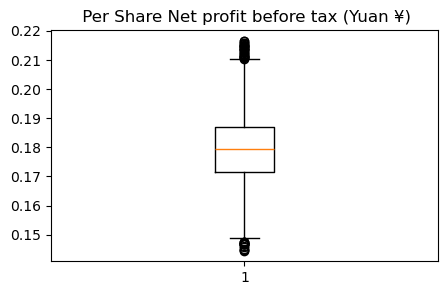

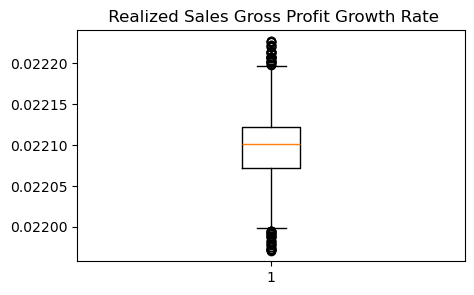

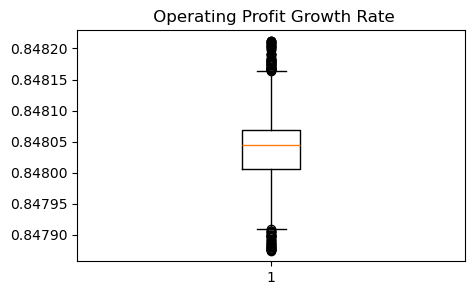

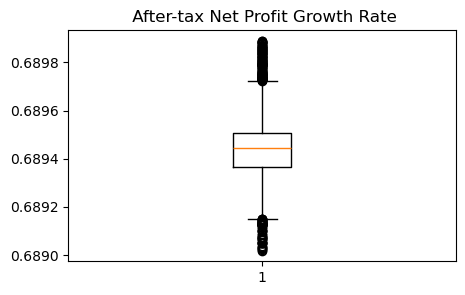

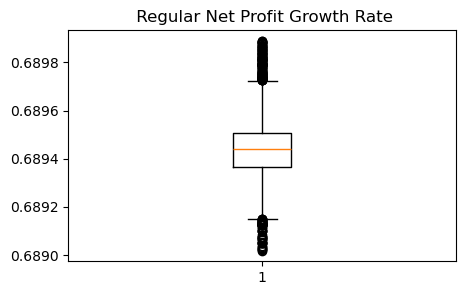

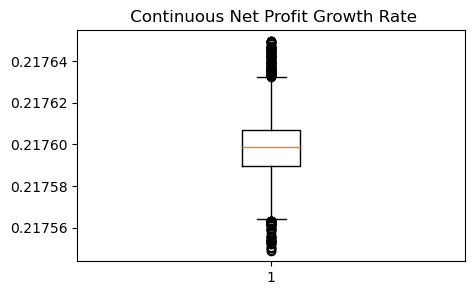

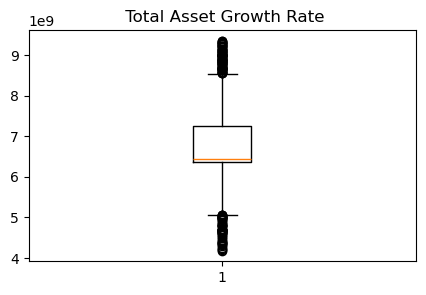

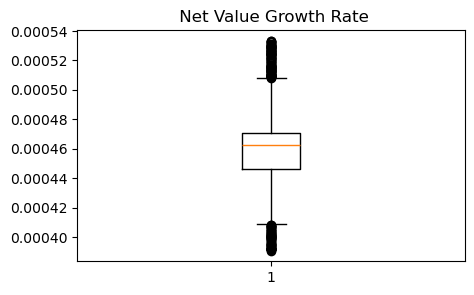

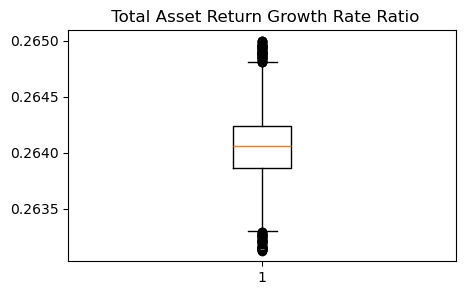

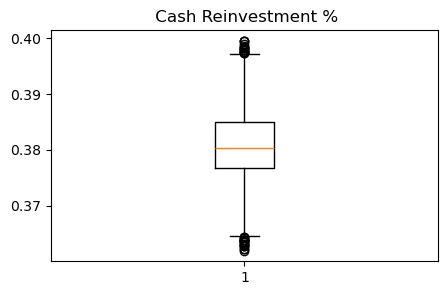

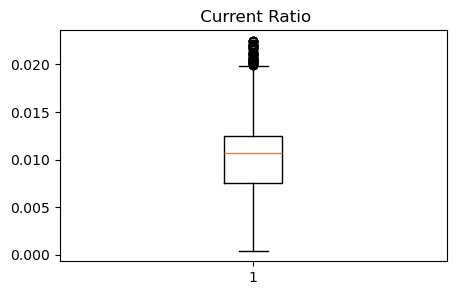

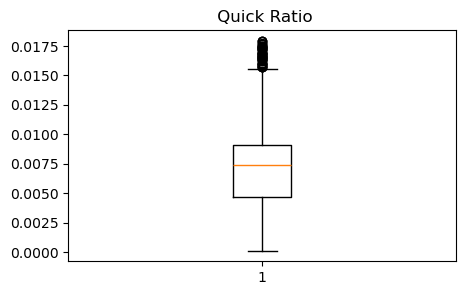

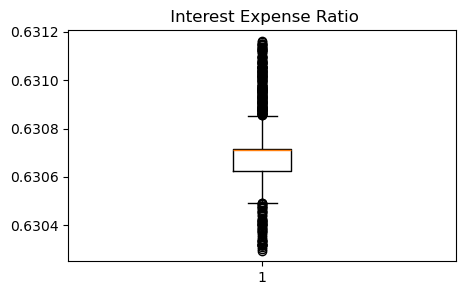

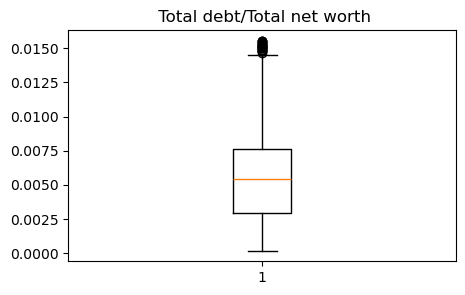

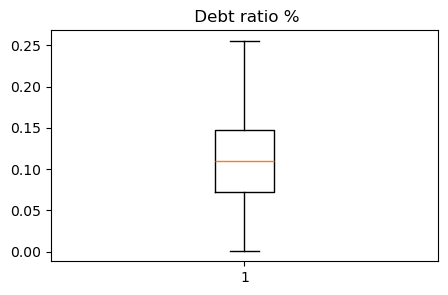

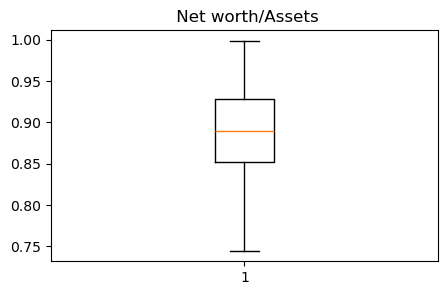

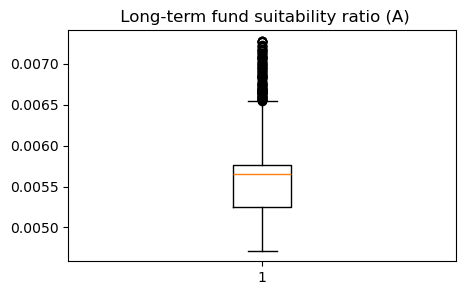

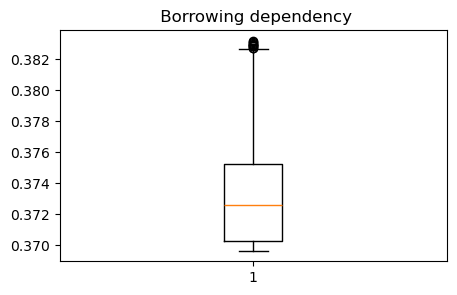

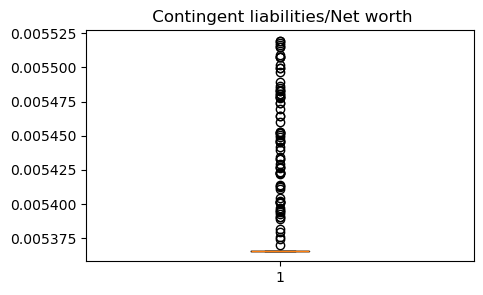

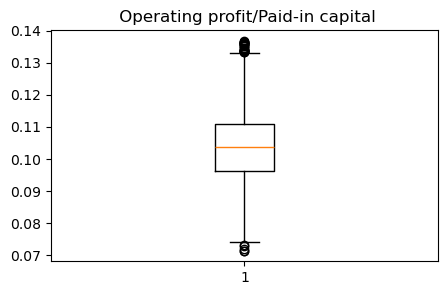

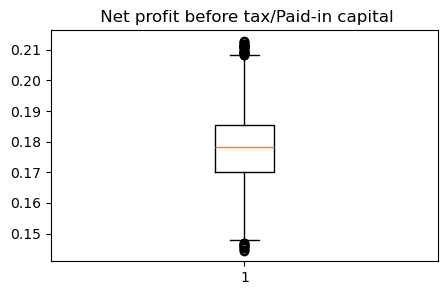

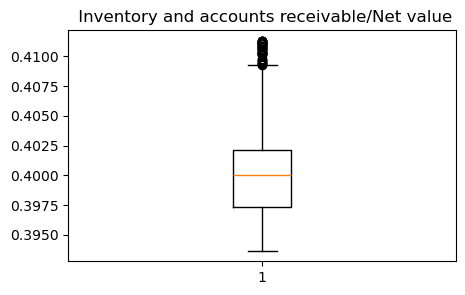

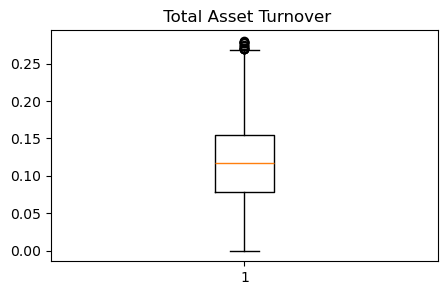

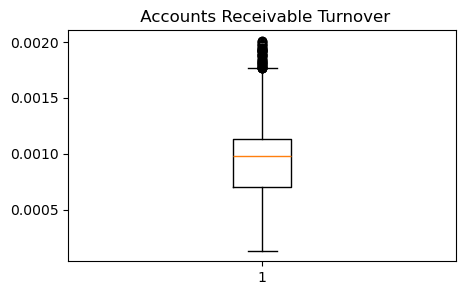

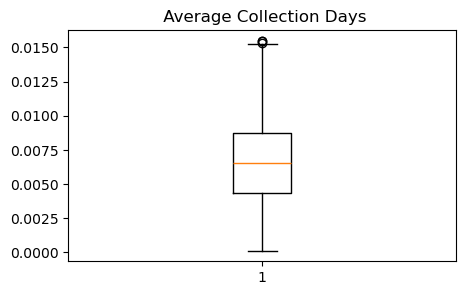

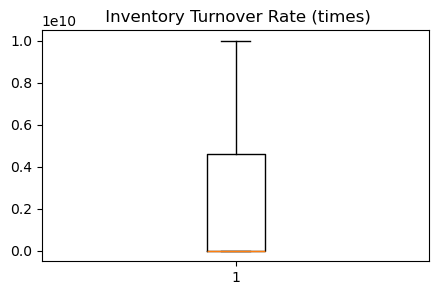

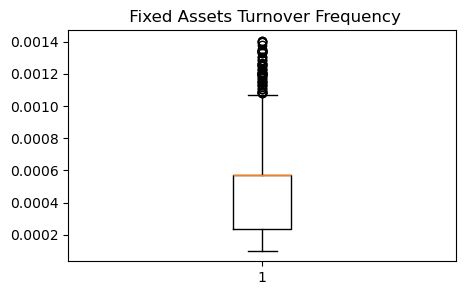

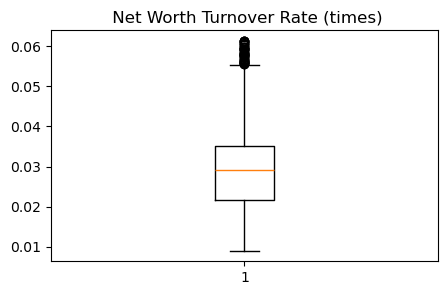

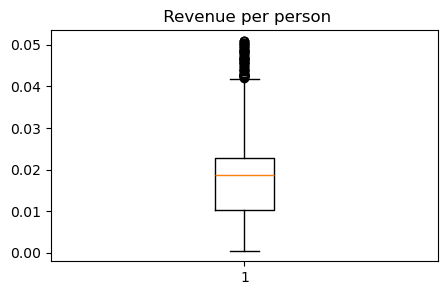

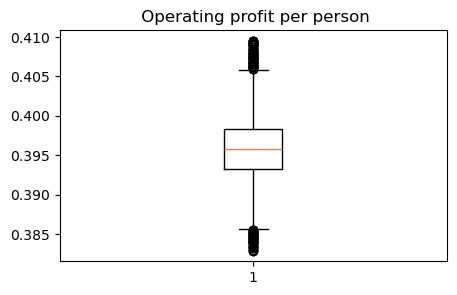

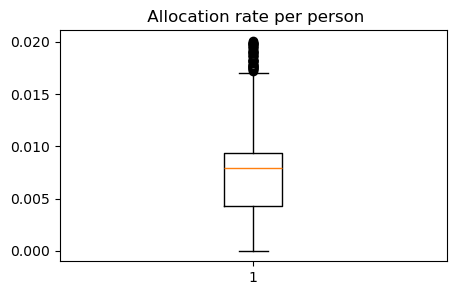

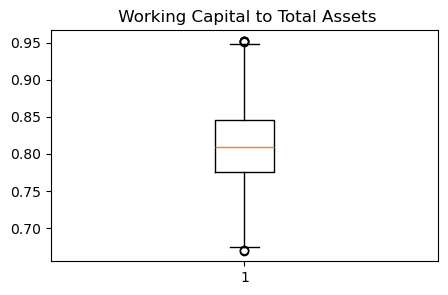

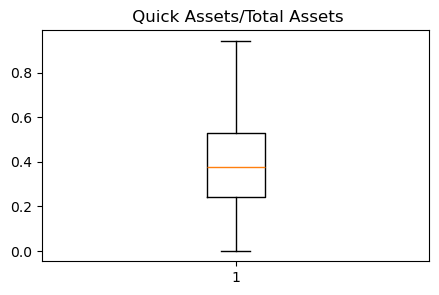

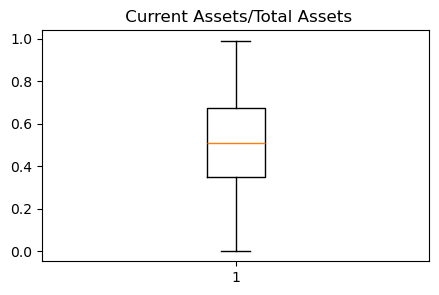

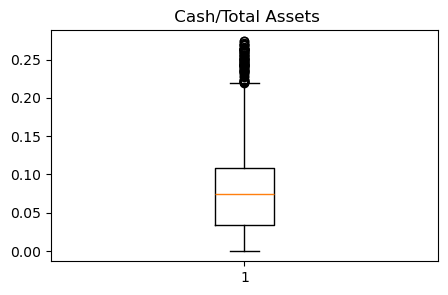

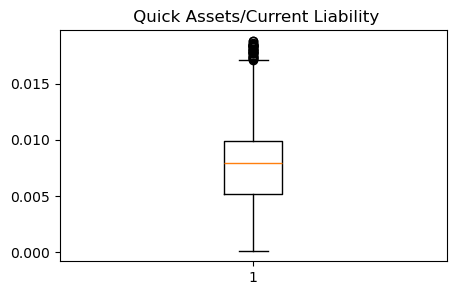

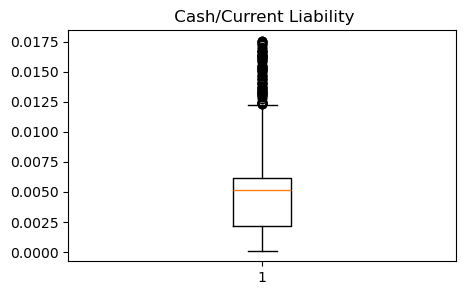

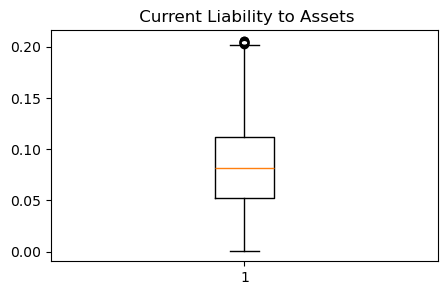

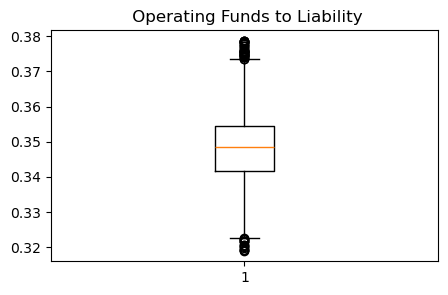

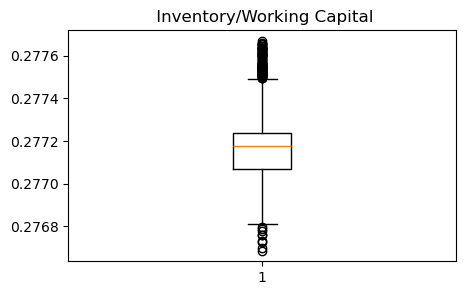

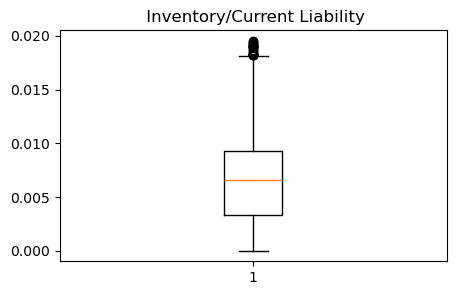

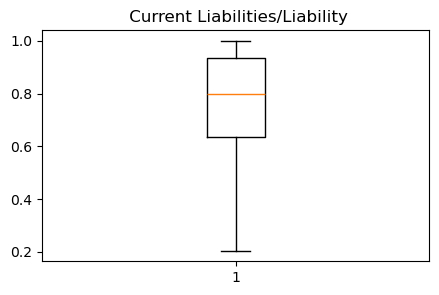

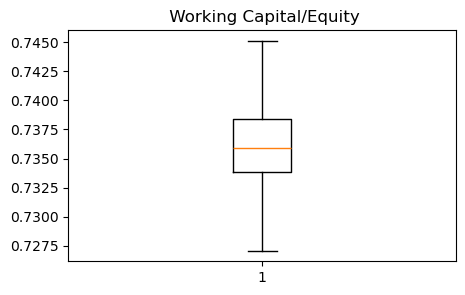

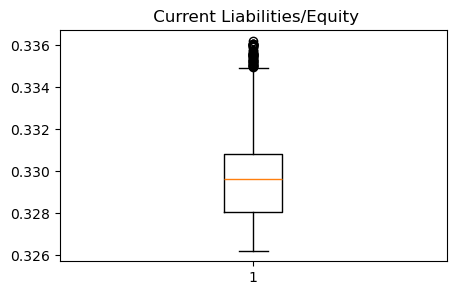

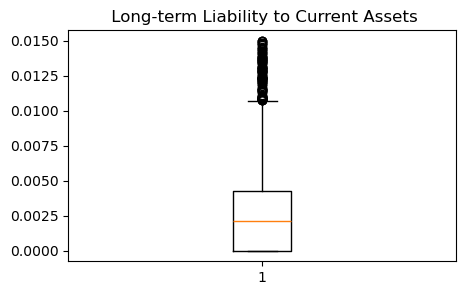

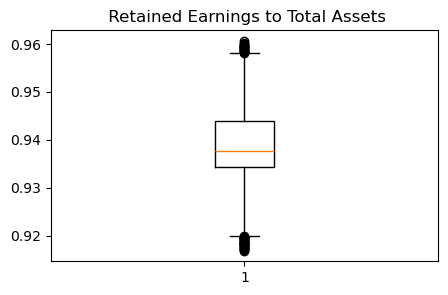

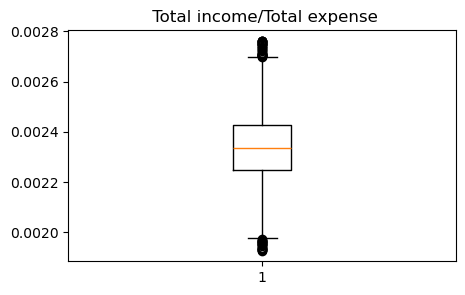

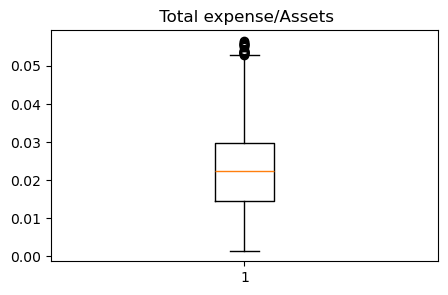

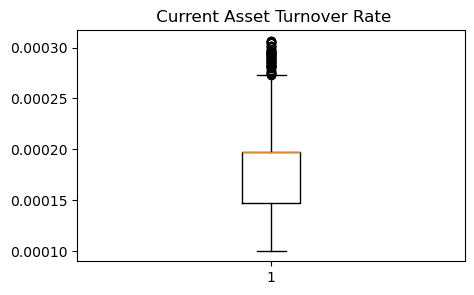

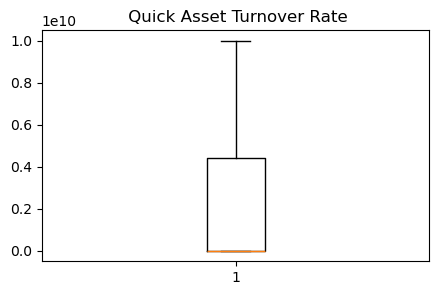

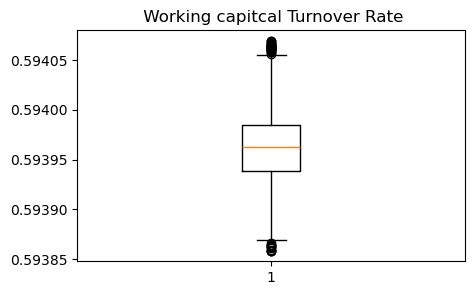

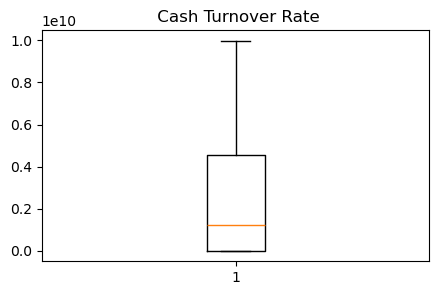

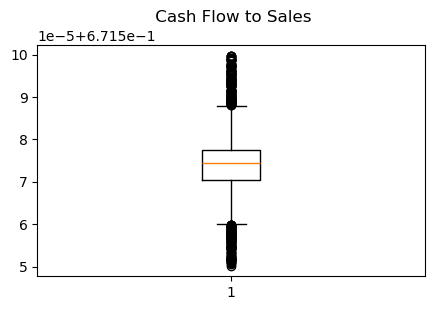

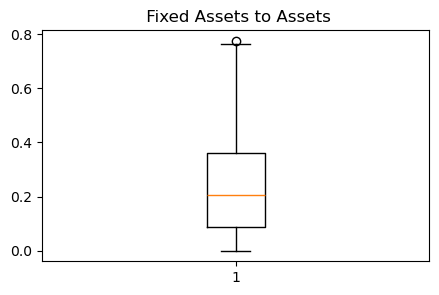

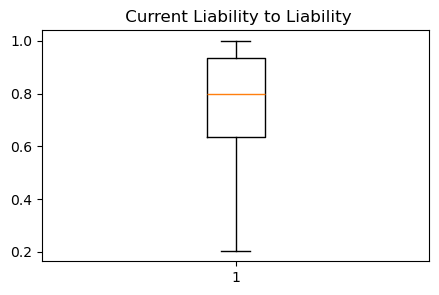

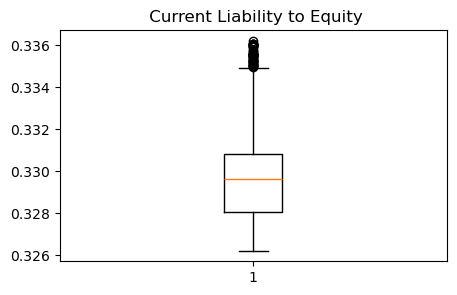

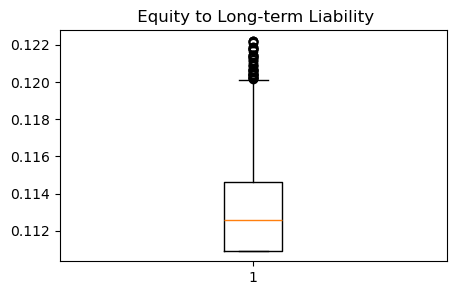

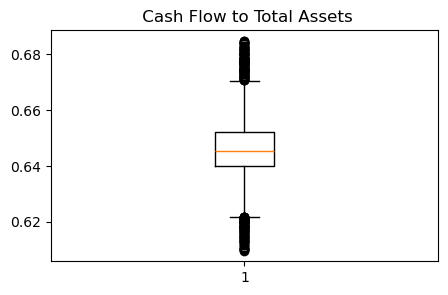

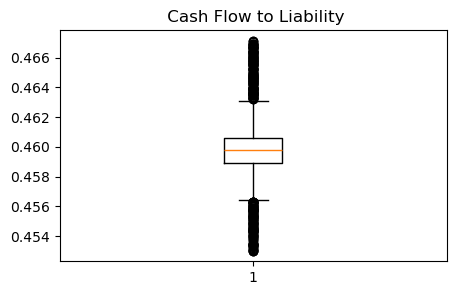

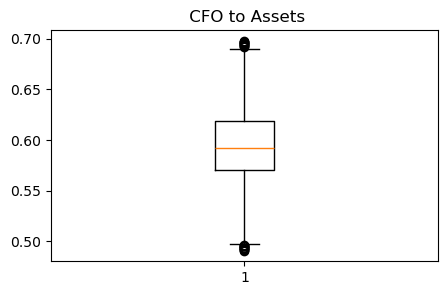

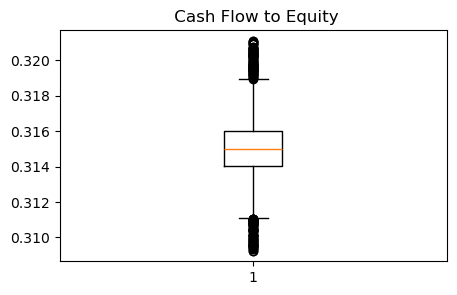

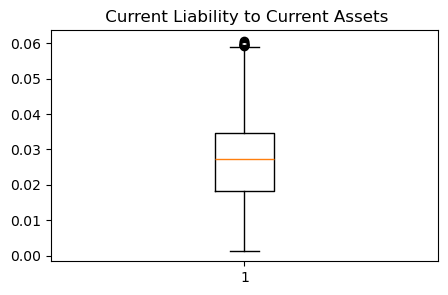

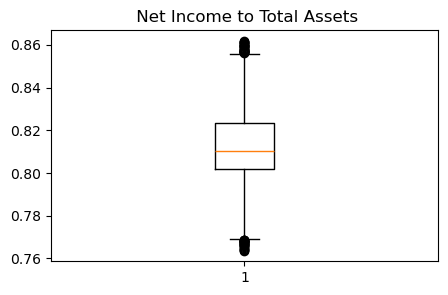

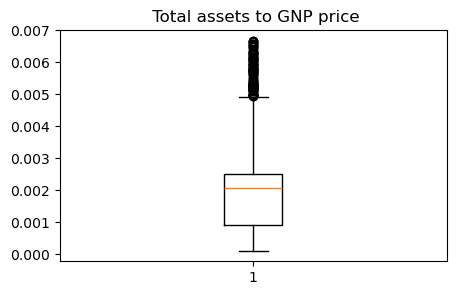

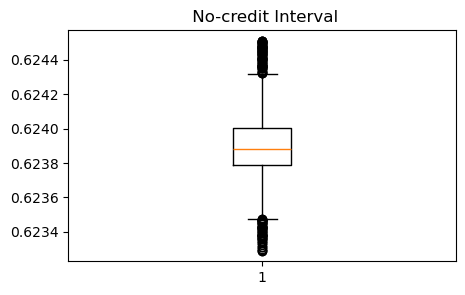

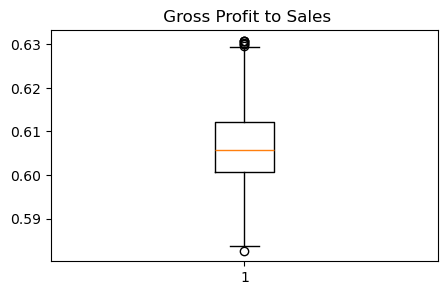

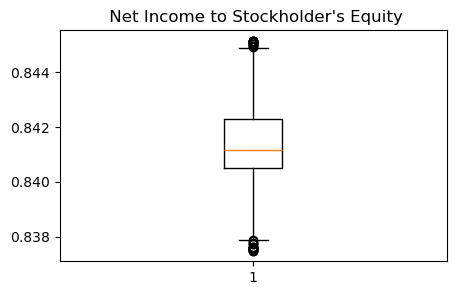

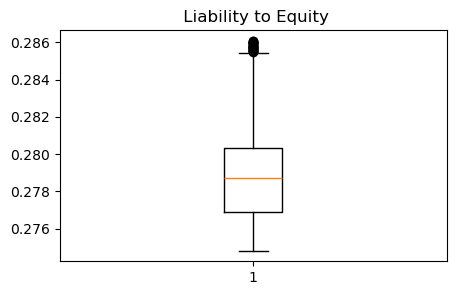

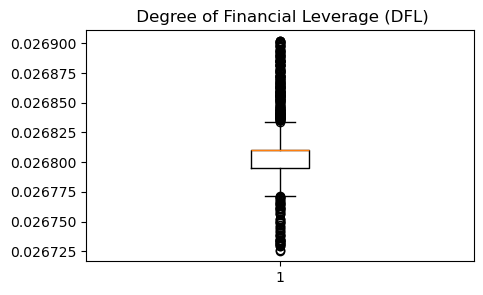

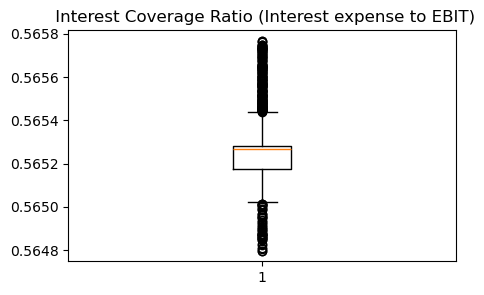

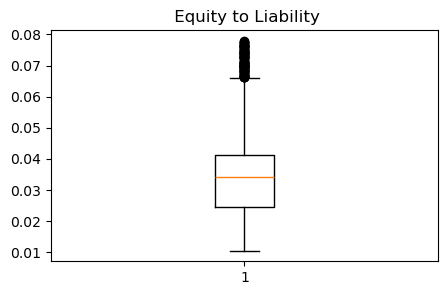

In [122]:
for column in df_x.columns:
    plt.figure(figsize=(5, 3))  # Rozmiar każdego wykresu
    plt.boxplot(df_x[column])  # Rysowanie wykresu pudełkowego dla konkretnej zmiennej
    plt.title(column)  # Tytuł wykresu
    plt.show()

In [ ]:
df_x = normalize_data(df_x)
x_train = normalize_data(x_train)

In [67]:
df_x

,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Revenue Per Share (Yuan ¥),Total Asset Growth Rate,Net Value Growth Rate,Quick Ratio,Total debt/Total net worth,Accounts Receivable Turnover,Average Collection Days,...,Revenue per person,Allocation rate per person,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Total assets to GNP price
0,4.298711e-15,7.094188e-01,5.333867e-13,0.115332,8.428428e-01,0.024492,5.236903e-13,3.424554e-12,1.287654e-13,6.414009e-13,...,2.755085e-12,6.809031e-13,0.033005,2.273986e-13,8.728203e-13,5.395028e-13,2.030227e-15,7.797798e-01,3.176353e-01,5.554291e-14
1,1.452906e-01,6.973948e-02,2.343669e-13,0.045761,9.379379e-01,0.055854,5.080243e-13,1.336866e-12,1.179922e-13,6.936353e-13,...,1.540464e-12,2.370161e-12,0.032745,8.142624e-14,4.310886e-13,1.528289e-12,1.391251e-15,9.369369e-01,1.472946e-01,1.226276e-12
2,1.352182e-14,5.270541e-03,7.071414e-13,0.049820,8.998999e-01,0.030218,2.621529e-12,4.919626e-13,9.157222e-14,8.668655e-13,...,2.056730e-12,1.314668e-12,0.153187,6.195596e-13,1.108262e-12,3.175696e-13,7.356176e-15,5.797579e-15,3.627255e-01,4.722040e-14
3,7.474950e-02,7.875752e-01,8.243249e-13,0.135226,7.127127e-01,0.024272,1.183478e-12,1.181551e-12,6.748642e-13,1.231384e-13,...,7.800658e-12,1.766785e-12,0.068086,2.814130e-12,1.150034e-12,6.924282e-13,9.487437e-01,7.177177e-01,7.418581e-15,5.939167e-12
4,2.505010e-01,7.144289e-02,2.474995e-13,0.079489,2.207122e-16,0.030657,4.696987e-13,2.542070e-12,1.297914e-13,6.371161e-13,...,2.161317e-12,4.348777e-12,0.026116,2.656400e-13,1.824488e-13,7.111579e-12,7.487437e-01,7.107107e-01,4.238477e-01,2.471362e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,4.194430e-15,0.000000e+00,5.778356e-13,0.015349,6.516517e-01,0.022593,4.332614e-13,9.665804e-13,9.465028e-14,8.425847e-13,...,1.000448e-12,9.023385e-13,0.036101,2.785665e-13,1.496703e-12,0.000000e+00,1.492779e-14,2.995956e-15,5.661323e-01,6.600681e-14
1428,1.282565e-01,5.100200e-03,1.606221e-13,0.045933,3.533534e-01,0.013002,1.346712e-12,6.554245e-13,6.002213e-14,1.230976e-12,...,5.514504e-11,1.654820e-12,0.078620,2.477581e-12,1.722071e-13,0.000000e+00,1.001856e-14,1.041744e-14,2.505655e-14,1.471622e-12
1429,6.256884e-15,3.847695e-01,2.485097e-13,0.066770,6.466466e-01,0.024830,1.485957e-12,1.126363e-12,6.823028e-14,1.109266e-12,...,3.579277e-12,1.052657e-12,0.089036,7.279782e-13,4.087604e-13,1.133197e-13,6.611884e-15,6.094772e-15,7.364729e-03,1.047671e-13
1430,6.492986e-01,3.757515e-01,4.091318e-13,0.051964,6.976977e-01,0.024101,1.466794e-12,5.077306e-13,1.487728e-13,5.624373e-13,...,1.565048e-12,1.392159e-12,0.089303,2.848422e-12,3.152094e-13,0.000000e+00,5.545510e-15,5.477006e-15,1.734599e-14,9.102371e-12


### From now on, we'll use x_train to train the data and df_x will be used for predictions

### Lasso

In [68]:
# Standaryzacja danych treningowych
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Standaryzacja danych testowych
x_test_scaled = scaler.transform(df_x)

# Tworzenie modelu regresji LassoCV z standaryzowanymi danymi
lasso_cv = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10], max_iter=1000, cv=5)
lasso_cv.fit(x_train_scaled, y_train)

# Wybieramy najlepszą wartość alpha dla naszych danych
best_alpha = lasso_cv.alpha_
print("Najlepsza wartość alpha:", best_alpha)

# Score dla danych treningowych
train_score = lasso_cv.score(x_train_scaled, y_train)
# Score dla danych testowych
test_score = lasso_cv.score(x_test_scaled, df_y)
print("Wynik dla danych treningowych:", train_score)
print("Wynik dla danych testowych:", test_score)

Najlepsza wartość alpha: 0.01
Wynik dla danych treningowych: 0.002199850992314012
Wynik dla danych testowych: 0.0007069873324004883


In [69]:
## Jak widać lasso dało praktycznie zerowe accuracy.

### Logistic Regression

In [82]:
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

In [83]:
pred = lr_model.predict(df_x)

In [84]:
df_x

,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Revenue Per Share (Yuan ¥),Total Asset Growth Rate,Net Value Growth Rate,Quick Ratio,Total debt/Total net worth,Accounts Receivable Turnover,Average Collection Days,...,Revenue per person,Allocation rate per person,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Total assets to GNP price
0,4.298711e-15,7.094188e-01,5.333867e-13,0.115332,8.428428e-01,0.024492,5.236903e-13,3.424554e-12,1.287654e-13,6.414009e-13,...,2.755085e-12,6.809031e-13,0.033005,2.273986e-13,8.728203e-13,5.395028e-13,2.030227e-15,7.797798e-01,3.176353e-01,5.554291e-14
1,1.452906e-01,6.973948e-02,2.343669e-13,0.045761,9.379379e-01,0.055854,5.080243e-13,1.336866e-12,1.179922e-13,6.936353e-13,...,1.540464e-12,2.370161e-12,0.032745,8.142624e-14,4.310886e-13,1.528289e-12,1.391251e-15,9.369369e-01,1.472946e-01,1.226276e-12
2,1.352182e-14,5.270541e-03,7.071414e-13,0.049820,8.998999e-01,0.030218,2.621529e-12,4.919626e-13,9.157222e-14,8.668655e-13,...,2.056730e-12,1.314668e-12,0.153187,6.195596e-13,1.108262e-12,3.175696e-13,7.356176e-15,5.797579e-15,3.627255e-01,4.722040e-14
3,7.474950e-02,7.875752e-01,8.243249e-13,0.135226,7.127127e-01,0.024272,1.183478e-12,1.181551e-12,6.748642e-13,1.231384e-13,...,7.800658e-12,1.766785e-12,0.068086,2.814130e-12,1.150034e-12,6.924282e-13,9.487437e-01,7.177177e-01,7.418581e-15,5.939167e-12
4,2.505010e-01,7.144289e-02,2.474995e-13,0.079489,2.207122e-16,0.030657,4.696987e-13,2.542070e-12,1.297914e-13,6.371161e-13,...,2.161317e-12,4.348777e-12,0.026116,2.656400e-13,1.824488e-13,7.111579e-12,7.487437e-01,7.107107e-01,4.238477e-01,2.471362e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,4.194430e-15,0.000000e+00,5.778356e-13,0.015349,6.516517e-01,0.022593,4.332614e-13,9.665804e-13,9.465028e-14,8.425847e-13,...,1.000448e-12,9.023385e-13,0.036101,2.785665e-13,1.496703e-12,0.000000e+00,1.492779e-14,2.995956e-15,5.661323e-01,6.600681e-14
1428,1.282565e-01,5.100200e-03,1.606221e-13,0.045933,3.533534e-01,0.013002,1.346712e-12,6.554245e-13,6.002213e-14,1.230976e-12,...,5.514504e-11,1.654820e-12,0.078620,2.477581e-12,1.722071e-13,0.000000e+00,1.001856e-14,1.041744e-14,2.505655e-14,1.471622e-12
1429,6.256884e-15,3.847695e-01,2.485097e-13,0.066770,6.466466e-01,0.024830,1.485957e-12,1.126363e-12,6.823028e-14,1.109266e-12,...,3.579277e-12,1.052657e-12,0.089036,7.279782e-13,4.087604e-13,1.133197e-13,6.611884e-15,6.094772e-15,7.364729e-03,1.047671e-13
1430,6.492986e-01,3.757515e-01,4.091318e-13,0.051964,6.976977e-01,0.024101,1.466794e-12,5.077306e-13,1.487728e-13,5.624373e-13,...,1.565048e-12,1.392159e-12,0.089303,2.848422e-12,3.152094e-13,0.000000e+00,5.545510e-15,5.477006e-15,1.734599e-14,9.102371e-12


Accuracy: 0.9699720670391061
Precision: 0.0
Recall: 0.0
F1-score: 0.0


C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


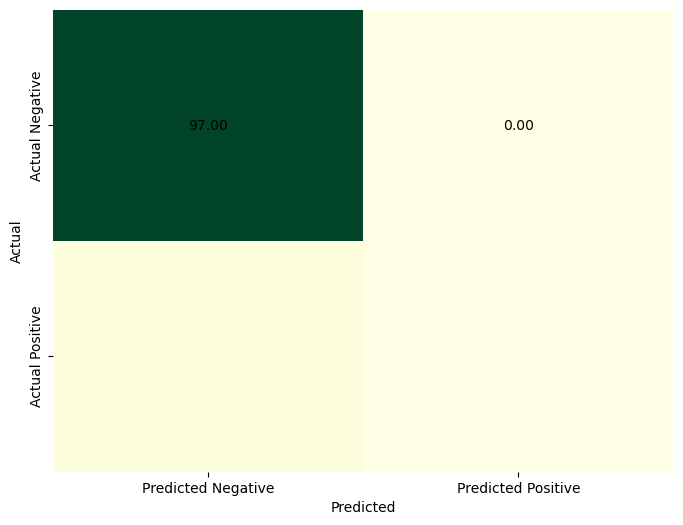

fp percent:0.0, fn percent:3.0027932960893855, tp percent:0.0, tn percent:96.9972067039106


In [85]:
calculate_metrics(df_y, pred)

#zobaczmy co się stanie jak dodamy wagę

In [74]:
lr2_model = LogisticRegression(max_iter=10000, class_weight='balanced')
lr2_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [75]:
pred = lr2_model.predict(df_x)

Accuracy: 0.6815642458100558
Precision: 0.046153846153846156
Recall: 0.4883720930232558
F1-score: 0.08433734939759036


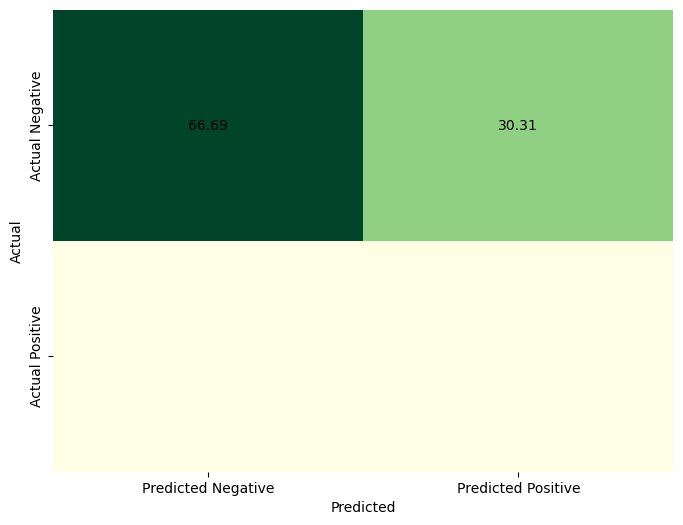

fp percent:30.307262569832403, fn percent:1.536312849162011, tp percent:1.4664804469273742, tn percent:66.68994413407822


In [76]:
calculate_metrics(df_y, pred)

# DecisionTREE

In [77]:
DT_model = DecisionTreeClassifier() # Create a decision tree classifier object

DT_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [78]:
pred = DT_model.predict(df_x)

Accuracy: 0.9329608938547486
Precision: 0.07936507936507936
Recall: 0.11627906976744186
F1-score: 0.09433962264150943


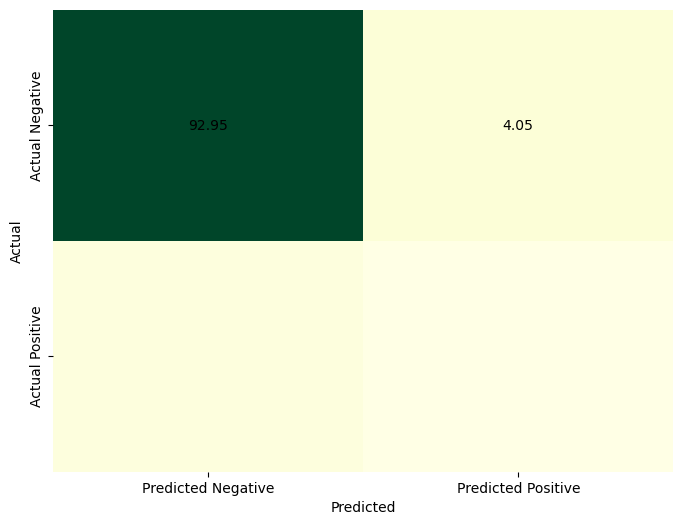

fp percent:4.050279329608938, fn percent:2.653631284916201, tp percent:0.34916201117318435, tn percent:92.94692737430168


In [79]:
calculate_metrics(df_y, pred)

# Random Forest

In [80]:
RF_model = RandomForestClassifier()

RF_model.fit(x_train, y_train)

predictions = RF_model.predict(df_x)



Accuracy: 0.9706703910614525
Precision: 1.0
Recall: 0.023255813953488372
F1-score: 0.09433962264150943


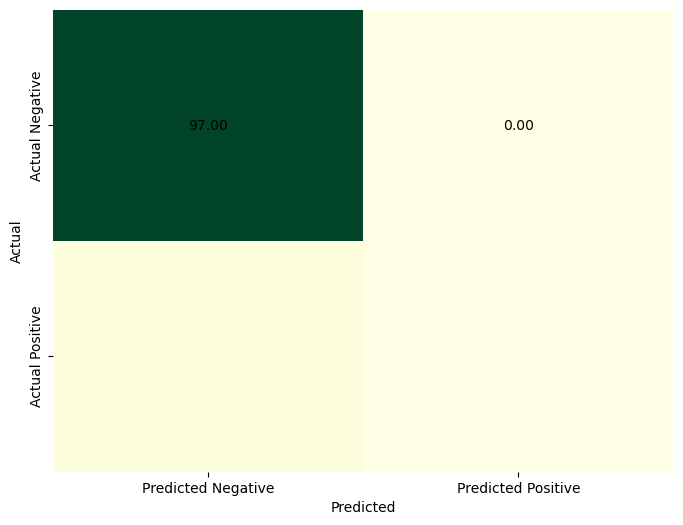

fp percent:0.0, fn percent:2.9329608938547485, tp percent:0.06983240223463687, tn percent:96.9972067039106


In [81]:
calculate_metrics(df_y, predictions)